In [1]:

import os 
import pickle 
import evaluate_predictions
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np 
import pstats
import re
import warnings

datapath = "../data/"
path_efficiencytest = f"{datapath}efficiency_test/"
path_profiling = f"{path_efficiencytest}profile/"
msmarcopath = f"{datapath}msmarco/"
name_aida_dataset = "aida_testB"

def filter_df(df, keep_strings, src):
    "Filter a dataframe with timings by function. Keep timings for functions with keep_strings."
    df = df.loc[df["fn"].str.contains(keep_strings), :].copy()
    df = df.loc[df['fn'] != "predict"] # predict calls with_coref, get_data_items, __predict
    df['src'] = src
    return df 


## Overview

### Changes to software
- add coref switch to REL and REBL
- return indicator for whether a mention is identified as a coreference
- time ED for msmarco by document -- script separate from REBL 
- add option whether only coreferences should be checked in evaluate_predictions
    - run `find_coref` on the mentions of the gold entities 



### Analysing efficiency and effectiveness
- Questions to be answered
    - Does `with_coref` impact the efficiency and effectiveness of REL? 
    - Given the time complexity of `with_coref`, does `with_coref` impact the efficiency differently for documents with more vs fewer mentions?
- Efficiency: large overhead from `__predict`,  the quadratic time complexity of `with_coref` starts to dominate the overal running time of entity disambiguation only for documents with 4000 mentions or more. This holds for both of the following two data sets:
    - AIDA: not a large number of mentions. $\rightarrow$ Create fake data for AIDA: stack the same mentions multiple times onto each other to generate a document with many mentions 
    - Use the msmarco data (tagged mentions from Chris)
- Effectiveness
    1. AIDA: Compare aggregate precision, recall when using `with_coref` and when not 
        - similar results independently of whether `with_coref` is used 
    2. AIDA: Compare precision and recall only for mentions that are coreferences
        - Find coreference mentions in the gold entities
        - Subset detected mentions to only coreferences 
        - *Result 1--comparing the coreference sample to the full sample of mentions*: For coreferences in general, precision is the same for coreferences and for the full sample, recall is only 25 percent. The main reason for this is low recall in the mention detection part.
        - *Result 2--comparing within coreference sample between `with_coref` and not*: Both precision and recall are a bit lower when not using `with_coref`, but the difference is small.
    3. msmarco: no ground truth. For tagged mentions, compare predicted entities when using `with_coref` and when not using it. 
        - 60 percent of coreferring mentions are linked to a different entity when using `with_coref` versus when not using it. 
        - The results perhaps suggest that this difference gets larger with more mentions, but we do not have enough large documents to test this directly



#### Main implications for REL
1. There may be a tradeoff efficiency-effectiveness for large number of mentions, but not enough data to test seriously. using a clustering algorithm for the coreferences could strike a balance
    - For small number of mentions, `with_coref` can be kept. Since this is known before the ED step, `with_coref` can be switched on and off depending on the document size 
    - What to do for large number of mentions?
        - In some cases with large, the user may ex-ante expect there to be many or few coreferences, and choose the option accordingly
        - In other cases not. What to do here? Is there a more efficient alternative to with_coref. Using only k surrounding sentences? is there a theory as to where coreferences are more likely to occur (ie, always after the mention appears for the first time)
            - Note that this is testable in the data (at least the ones we have)
2. An important reason for low recall for coreferences is the mention detection, not the disambiguation. can we try to improve MD for the coreferences?


### Next steps 
- check whether the 10% coreferring entities have higher recall/precision (?) -- do the above results not imply that they have lower precision/recall?
- add
    - msmarco: calculate ED overlap by number of mentions (in bins)
    - AIDA: check some specific examples of coreferences that are not detected in the MD step
- try out clustering algorithm for coreferences
    - which one?
    - ask Chris, Faegheh. Ask tech lead/in the teams chat?
    - what is the time complexity of the algorithm? 
- Faegheh/Erik/Stef/...
    - how and what to integrate from the changes mentioned above?
    - code review




## Compare ED aggregate predictions with/without coref, across data sets 

In [2]:
# load single data set 
files = os.listdir(f"{path_efficiencytest}/predictions")
predictions = {}

for f in files:
    with open(f"{path_efficiencytest}/predictions/{f}", "rb") as file:
        f = re.sub(".pickle", "", f)
        predictions[f] = pickle.load(file)

In [3]:
for version, d in predictions.items():
    # this only works for the aida test data sets 
    if "aida_test" in version:
        print(f"Evaluating predictions for {version}")
        evaluate_predictions.evaluate(d["predictions"])


Evaluating predictions for aida_testB_50_nocoref
Results: PMD RMD FMD PEL REL FEL: 97.4% 61.9% 75.7% | 65.7% 41.7% 51.0%
Evaluating predictions for aida_testB_500
Results: PMD RMD FMD PEL REL FEL: 97.9% 62.9% 76.6% | 62.1% 39.9% 48.6%
Evaluating predictions for aida_testB_500_nocoref
Results: PMD RMD FMD PEL REL FEL: 97.9% 62.9% 76.6% | 62.1% 39.9% 48.6%
Evaluating predictions for aida_testB_50
Results: PMD RMD FMD PEL REL FEL: 97.4% 61.8% 75.7% | 65.8% 41.7% 51.1%


## Compare ED predictions with/without coref for only mentions that are labelled as coreferences

**Approach**
- When running ED `with_coref`, label the identified mentions whether they are a coreference or not 
- For both predictions with and without coref, subset the predicted entities only to those mentions that were identified as coreferences.
- The gold entities also need to be adjusted
    - If we drop mentions that are not coreferences from our predictions, recall will mechanically decrease. And substantially so, because many mentions are not coreferences
    - Therefore, apply the same procedure to the gold entities: label them by whether they are coreferences, and only keep the gold entities that are coreferences.

In [4]:

# Subset predicted to those that are coreferences
n_documents = [50, 500] 
predictions_for_coreferences = {}

for n in n_documents:
    iteration_name = f"{name_aida_dataset}_{n}"
    iteration_name_nocoref = f"{iteration_name}_nocoref"

    predictions_coref = predictions[iteration_name]["predictions"]
    predictions_nocoref = predictions[iteration_name_nocoref]["predictions"]

    predicted_entities_coref = {}
    predicted_entities_nocoref = {}
    for docname, mentions_coref, mentions_nocoref in zip(predictions_coref.keys(), predictions_coref.values(), predictions_nocoref.values()):
        n_mentions = len(mentions_coref)
        # only keep the mentions that are labelled as coreferences. since we only have this information for the iteration where with_coref is used,
            # use the index of the mention list to subset
        prediction_coref = [mentions_coref[i] for i in range(n_mentions) if mentions_coref[i]['is_coref'] == 1]
        prediction_nocoref = [mentions_nocoref[i] for i in range(n_mentions) if mentions_coref[i]['is_coref'] == 1]
        
        predicted_entities_coref[docname] = prediction_coref 
        predicted_entities_nocoref[docname] = prediction_nocoref
    
    predictions_for_coreferences[iteration_name] = predicted_entities_coref
    predictions_for_coreferences[iteration_name_nocoref] = predicted_entities_nocoref


# Evaluate predictions. The adjustment for the gold entities is made in evaluate_predictions.evaluate()
for version, d in predictions_for_coreferences.items():
    # this only works for the aida test data sets 
    if "aida_test" in version:
        print(f"Evaluating predictions for {version}")
        evaluate_predictions.evaluate(d, coref_only=True)



Evaluating predictions for aida_testB_50
Results: PMD RMD FMD PEL REL FEL: 97.1% 26.2% 41.3% | 77.1% 20.8% 32.8%
Evaluating predictions for aida_testB_50_nocoref
Results: PMD RMD FMD PEL REL FEL: 97.1% 26.3% 41.4% | 75.7% 20.5% 32.3%
Evaluating predictions for aida_testB_500
Results: PMD RMD FMD PEL REL FEL: 97.4% 24.0% 38.5% | 78.8% 19.4% 31.2%
Evaluating predictions for aida_testB_500_nocoref
Results: PMD RMD FMD PEL REL FEL: 97.4% 24.1% 38.6% | 77.5% 19.1% 30.7%


**Notes**
- Results for aida_testB_50 refer to table 1 in Erik's document, row 2
    - the numbers exactly match 
- Comparing the full sample with the restricted sample (only coreferring mentions)
    1. Mention detection is much worse -- only 25 percent of mentions that are coreferences are identified. In the full sample, 60 percent of all gold mentions are detected. This could be (1) because coreferences are harder to detect, or (2) because some detected mentions are not labelled as coreferences because the mention they are referring to is not detected. I think case (1) is more likely.
    2. Entity disambiguation: Precision is higher for coreferences than for the full sample. Recall is lower for coreferences than for the full sample. 
- Comparing effectiveness for coreferences when using `with_coref` and when not using it
    1. Whether `with_coref` or not is used not impact effectiveness a lot -- F1 scores are very similar when `with_coref` is used and when it is not.
    2. These facts indicate that turning off `with_coref` does on average only slightly worsen entity linking effectiveness.



## Profile ED with/without coref, across data sets

In [5]:
files = os.listdir(path_profiling)
predictions_profile = {}

for file in files:
    f = f"{path_profiling}{file}"
    d = pd.read_csv(f)
    file = re.sub(".csv", "", file)
    predictions_profile[file] = d


In [6]:
d_list = []
keep_strings = 'predict|with_coref'

for filename, d in predictions_profile.items():
    data = d.loc[d['fn'].str.contains(keep_strings), :].copy()
    data = data.loc[data['fn'] != 'predict', :]
    data['src'] = filename
    d_list.append(data)

df = pd.concat(d_list)



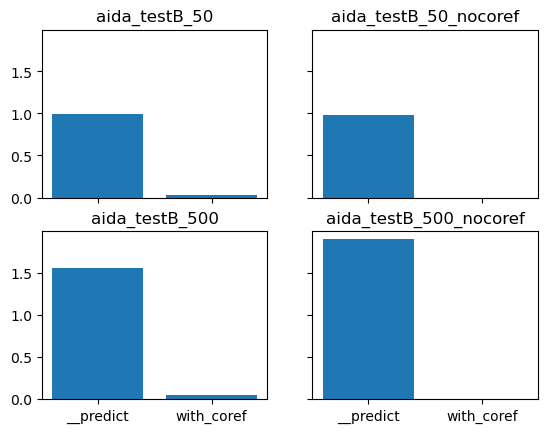

In [18]:
groups = df['src'].unique()
groups = sorted(groups, key=lambda x: re.sub("_nocoref", "", x))
idxs = [[x, y] for y in range(2) for x in range(2)]

fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True)

i = 0
for g in groups:
    dtemp = df.loc[df.src == g]
    col_idx = idxs[i][0]
    row_idx = idxs[i][1]
    x = dtemp['fn']
    y = dtemp['cumtime']
    axs[row_idx, col_idx].bar(x=x, height=y)
    axs[row_idx, col_idx].set_title(g)
    i += 1




## Time complexity of entity disambiguation

Procedure
1. Create datasets with many more mentions by stacking the mentions from the same document multiple times 
2. Measure: total runtime of ED, profile ED for timing of `__predict` and `with_coref`
3. Compare time complexity 


In [19]:
time_dataset = {}
inputs = {
    "coref_yes": "",
    "coref_no": "_nocoref"
}
path_mentions_time = f"{path_efficiencytest}n_mentions_time/"
for k, suffix in inputs.items():
    with open(f"{path_mentions_time}{name_aida_dataset}{suffix}.pickle", "rb") as file:
        data = pickle.load(file)
        time_dataset[k] = data



In [9]:

timing_overall = {}
for condition, conditiondata in time_dataset.items():
    d = []
    for docid, data in conditiondata.items():
        temp2 = {docid: {measure: value for measure, value in data.items() if measure in ["n_mentions", "time"]}}
        temp2 = pd.DataFrame.from_dict(temp2, orient="index")
        d.append(temp2)
    timing_overall[condition] = pd.concat(d)



Text(0.5, 1.0, 'Measured time for ED with and without coref')

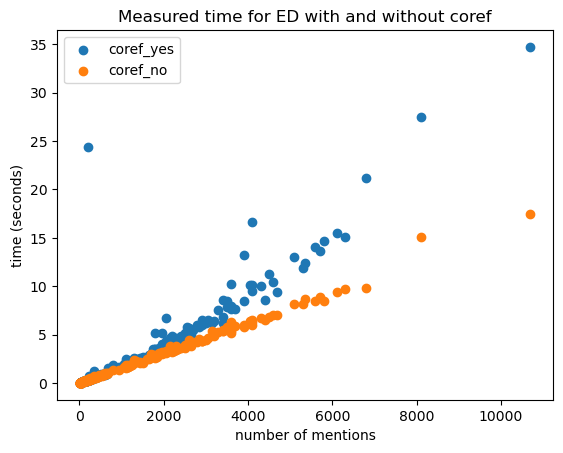

In [10]:
fig, ax = plt.subplots()

for lbl, d in timing_overall.items():
    x = d['n_mentions']
    y = d['time']
    ax.scatter(x=x, y=y, label=lbl)

ax.legend()
ax.set_xlabel("number of mentions")
ax.set_ylabel("time (seconds)")
ax.set_title("Measured time for ED with and without coref")

In [11]:
timing_profile = []
for condition, conditiondata in time_dataset.items():
    print(condition)
    d = []
    for docid, data in conditiondata.items():
        d_profile = filter_df(data["profile"], keep_strings=keep_strings, src=filename)
        d_profile['n_mentions'] = data['n_mentions']
        d.append(d_profile)
    df_out = pd.concat(d)
    df_out['condition'] = condition
    timing_profile.append(df_out)
    
# do the same for the profiling output, process as above 
timing_profile = pd.concat(timing_profile)


coref_yes
coref_no


In [12]:
timing_profile.head()

,file,line,fn,cc,ncalls,tottime,cumtime,callers,src,n_mentions,condition
118,/home/flavio/projects/rel20/REL/src/REL/entity...,521,__predict,1,1,0.000380,0.018163,{('/home/flavio/projects/rel20/REL/src/REL/ent...,aida_testB_50_nocoref,39,coref_yes
168,/home/flavio/projects/rel20/REL/src/REL/traini...,108,with_coref,1,1,0.000019,0.000451,{('/home/flavio/projects/rel20/REL/src/REL/ent...,aida_testB_50_nocoref,39,coref_yes
119,/home/flavio/projects/rel20/REL/src/REL/entity...,521,__predict,1,1,0.047441,0.498564,{('/home/flavio/projects/rel20/REL/src/REL/ent...,aida_testB_50_nocoref,195,coref_yes
168,/home/flavio/projects/rel20/REL/src/REL/traini...,108,with_coref,1,1,0.000125,0.017074,{('/home/flavio/projects/rel20/REL/src/REL/ent...,aida_testB_50_nocoref,195,coref_yes
119,/home/flavio/projects/rel20/REL/src/REL/entity...,521,__predict,1,1,0.109560,0.649034,{('/home/flavio/projects/rel20/REL/src/REL/ent...,aida_testB_50_nocoref,390,coref_yes


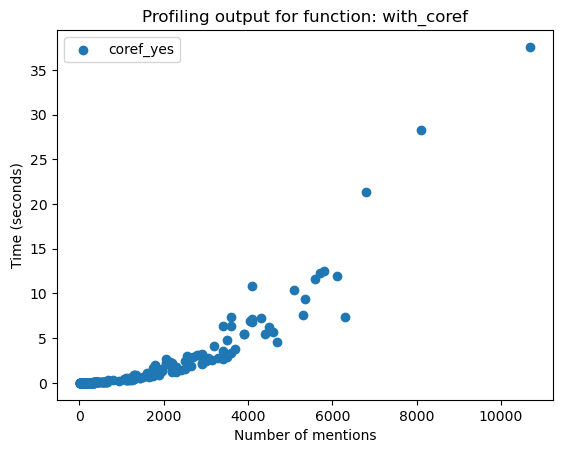

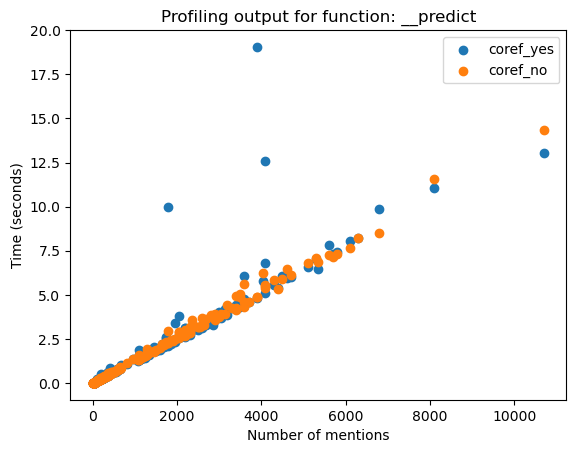

In [13]:

xlabel = 'Number of mentions'
ylabel = 'Time (seconds)'

for fnc in ['with_coref', '__predict']:
    fig, ax = plt.subplots()

    dtemp = timing_profile.loc[timing_profile['fn'] == fnc, :] # plot the timing for the function predict 
    conditions = dtemp['condition'].unique()

    for c in conditions:
        d = dtemp.loc[dtemp['condition'] == c, :]
        ax.scatter(x=d['n_mentions'], y=d['cumtime'], label=c)
        
    ax.legend()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(f"Profiling output for function: {fnc}")




Text(0.5, 1.0, 'Profiling output for __predict and with_coref with coref is on')

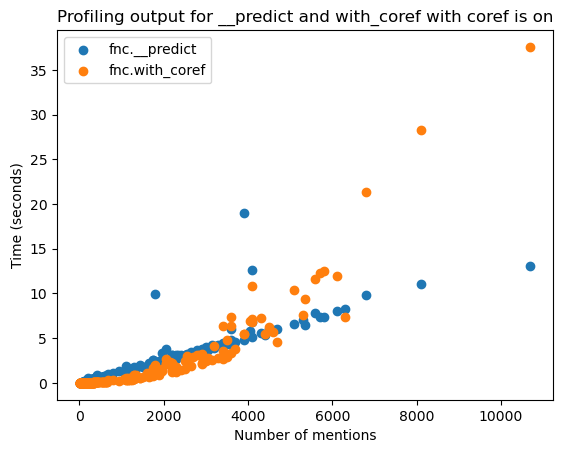

In [14]:
fig, ax = plt.subplots()
dtemp = timing_profile.loc[timing_profile['condition'] == "coref_yes", :]
functions_to_plot = ['__predict', 'with_coref']

for fn in functions_to_plot:
    fn_label = f"fnc.{fn}"
    d = dtemp.loc[dtemp['fn'] == fn, :]
    ax.scatter(x=d['n_mentions'], y=d['cumtime'], label=fn_label)


ax.legend()
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.set_title("Profiling output for __predict and with_coref with coref is on")

### Notes
- with_coref grows quadratically, that is expected 
- time for `__predict` does not depend on whether we use with_coref or not 
- the overhead of `__predict` is quite large (compared to the average number of mentions in the datasets I have looked at), only at around 4000 mentions the with_coref effects dominates 

## Compare predictions on data sets with many mentions

- Use the msmarco data 
- Run ED on the same file with detected mentions 
- Compare whether the linked entities are the same when using `with_coref` and when not using it

In [24]:
files_msmarco = ['ed_coref', 'ed_nocoref']
idx_cols = ["doc_id", "field", "start_pos", "end_pos"]

d_msmarco = {f: pd.read_parquet(f"{msmarcopath}predictions/{f}.parquet") for f in files_msmarco}

if d_msmarco["ed_coref"].shape[0] != d_msmarco["ed_nocoref"].shape[0]:
    warnings.warn("Not the same number of entities in the two datasets")

for df in d_msmarco.values():
    df.drop(columns=['md_score', 'ed_score'], inplace=True)
    df.set_index(idx_cols, inplace=True)


/tmp/ipykernel_8617/3885175289.py:7: UserWarning: Not the same number of entities in the two datasets
  warnings.warn("Not the same number of entities in the two datasets")


In [25]:
colnames_to_change = ["entity", "ed_score", "tag"]

for name, df in d_msmarco.items():
    cols = df.columns 
    new_colnames = [f"{x}_{name}" if x in colnames_to_change else x for x in cols]
    d_msmarco[name].columns = new_colnames


In [26]:

d_compare = (d_msmarco["ed_coref"]
                .join(d_msmarco["ed_nocoref"].drop(columns="is_coref"))
                .reset_index()
            )

d_compare['same_entity'] = np.where(d_compare["entity_ed_coref"] == d_compare["entity_ed_nocoref"], 1, 0)
assert d_compare.shape[0] == d_msmarco["ed_coref"].shape[0], "not the same number of entities in d_compare and ed_coref"

d_compare.groupby("is_coref")["same_entity"].describe()

,count,mean,std,min,25%,50%,75%,max
is_coref,,,,,,,,
0,247754.0,0.996791,0.056556,0.0,1.0,1.0,1.0,1.0
1,8767.0,0.402760,0.490481,0.0,0.0,0.0,1.0,1.0


Average overlap across documents (unweighted) for all: 0.991
Average overlap across documents (unweighted) for coref_only: 0.426
Average overlap across documents (unweighted) for no_coref: 0.999


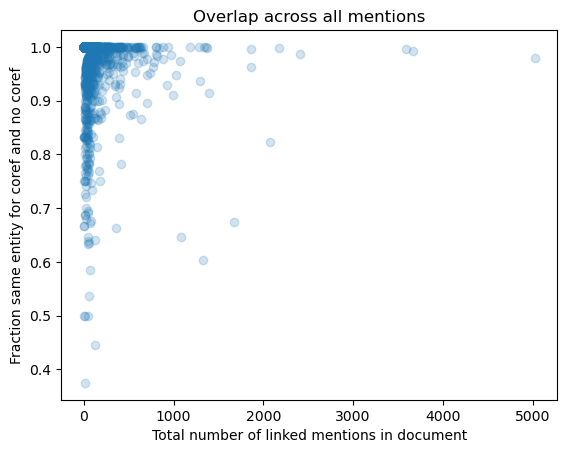

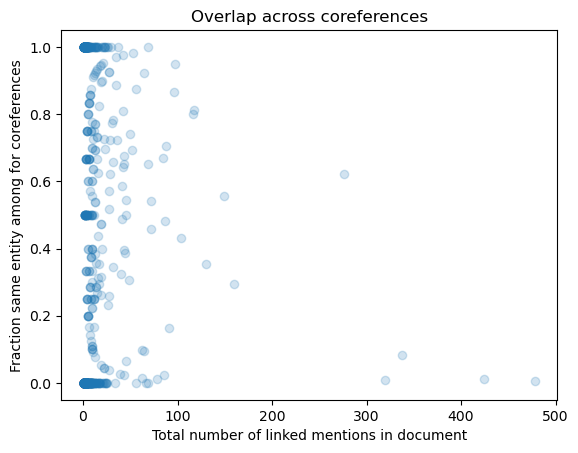

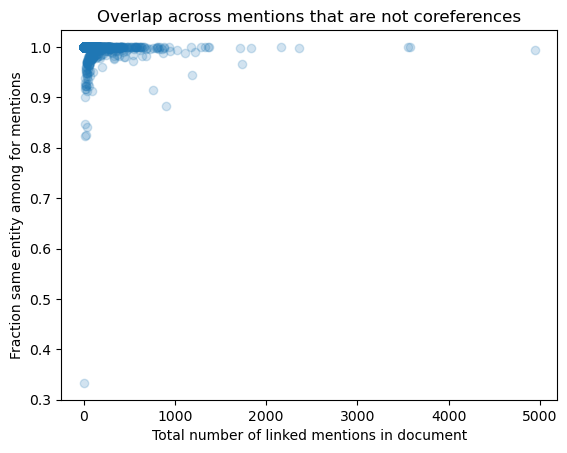

In [27]:
xlabel = 'Total number of linked mentions in document'

plt_inputs = {
        "all": {
                "df": d_compare,
                "ylabel": 'Fraction same entity for coref and no coref',
                "title": "Overlap across all mentions"
                },
        "coref_only": {
                "df": d_compare.loc[d_compare['is_coref']==1, :],
                "ylabel": 'Fraction same entity among for coreferences',
                "title": "Overlap across coreferences"
                },
        "no_coref": {
                "df": d_compare.loc[d_compare['is_coref']==0, :],
                "ylabel": 'Fraction same entity among for mentions',
                "title": "Overlap across mentions that are not coreferences"
        }
}


for sample, input in plt_inputs.items():
    df = input['df']
    # aggregate, join 
    d_agg = df.groupby(df['doc_id']).agg({"same_entity": "mean"})
    d_size = df.groupby(df['doc_id']).size().to_frame('n_mentions')

    d_agg = d_agg.join(d_size).reset_index()

    print(f"Average overlap across documents (unweighted) for {sample}: {round(d_agg.same_entity.mean(), 3)}")


    # plot 
    fig, ax = plt.subplots()
    ax.scatter(x=d_agg['n_mentions'], y=d_agg['same_entity'], alpha=0.2)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(input['ylabel']) 
    ax.set_title(input['title'])


In [38]:
help(np.quantile)

Help on function quantile in module numpy:

quantile(a, q, axis=None, out=None, overwrite_input=False, method='linear', keepdims=False, *, interpolation=None)
    Compute the q-th quantile of the data along the specified axis.
    
    .. versionadded:: 1.15.0
    
    Parameters
    ----------
    a : array_like
        Input array or object that can be converted to an array.
    q : array_like of float
        Quantile or sequence of quantiles to compute, which must be between
        0 and 1 inclusive.
    axis : {int, tuple of int, None}, optional
        Axis or axes along which the quantiles are computed. The default is
        to compute the quantile(s) along a flattened version of the array.
    out : ndarray, optional
        Alternative output array in which to place the result. It must have
        the same shape and buffer length as the expected output, but the
        type (of the output) will be cast if necessary.
    overwrite_input : bool, optional
        If True, then

In [60]:
dk = d_compare.copy()
d_agg = dk.loc[dk['is_coref'] == 1, :].groupby(dk['doc_id']).agg({"same_entity": "mean"})
d_size = dk.groupby(dk['doc_id']).size().to_frame('n_mentions')

d_agg = d_agg.join(d_size).reset_index()
d_agg.head()
np.quantile(a=d_agg['n_mentions'], q=[0.05, 0.1, 0.2, 0.3])



ValueError: Length of values (11) does not match length of index (643)

In [73]:
quantiles = np.linspace(0, 1, num=11)
np.quantile(a=d_agg["n_mentions"], q=quantiles)
# how to generate quantile column? how to group by quantile and summarise? 
# help(pd.DataFrame.quantile)
d_agg["qt"] = d_agg["n_mentions"].quantile([0.1, 0.5, 0.8])
d_agg.head()
# d_agg.describe()
# d_agg.qt.nunique()
# how to assign groups to quantile? 

,doc_id,same_entity,n_mentions,qt
0,msmarco_doc_00_10006201,0.65625,96,NaN
1,msmarco_doc_00_10047483,1.00000,41,NaN
2,msmarco_doc_00_10066925,0.00000,138,NaN
3,msmarco_doc_00_10210601,0.00000,277,NaN
4,msmarco_doc_00_10410008,0.50000,192,NaN


In [69]:
help(pd.DataFrame.quantile)

Help on function quantile in module pandas.core.frame:

quantile(self, q: 'float | AnyArrayLike | Sequence[float]' = 0.5, axis: 'Axis' = 0, numeric_only: 'bool | lib.NoDefault' = <no_default>, interpolation: 'QuantileInterpolation' = 'linear', method: "Literal['single', 'table']" = 'single') -> 'Series | DataFrame'
    Return values at the given quantile over requested axis.
    
    Parameters
    ----------
    q : float or array-like, default 0.5 (50% quantile)
        Value between 0 <= q <= 1, the quantile(s) to compute.
    axis : {0 or 'index', 1 or 'columns'}, default 0
        Equals 0 or 'index' for row-wise, 1 or 'columns' for column-wise.
    numeric_only : bool, default True
        If False, the quantile of datetime and timedelta data will be
        computed as well.
    
        .. deprecated:: 1.5.0
            The default value of ``numeric_only`` will be ``False`` in a future
            version of pandas.
    
    interpolation : {'linear', 'lower', 'higher', 'midpo

### Notes 
- Substantial differences for coreferences 
- Also a small impact on the predicted entities that are not coreferences. Is this just a coincidence, or is it systematic?

## Efficiency with msmarco data

In [21]:
n_docs = 5000 
files = os.listdir(f"{msmarcopath}/timing/")
files = [f for f in files if str(n_docs) in f]

timing_msmarco = {}

for f in files:
    with open(f"{datapath}msmarco/timing/{f}", "rb") as file:
        key = re.sub(f"_ndocs_{n_docs}.pickle", "", f)
        timing_msmarco[key] = pickle.load(file)

for key, data in timing_msmarco.items():
    df = pd.DataFrame.from_dict(data, orient="index").reset_index(names="docid")
    timing_msmarco[key] = df

Text(0.5, 1.0, 'msmarco: Measured time for ED with and without coref')

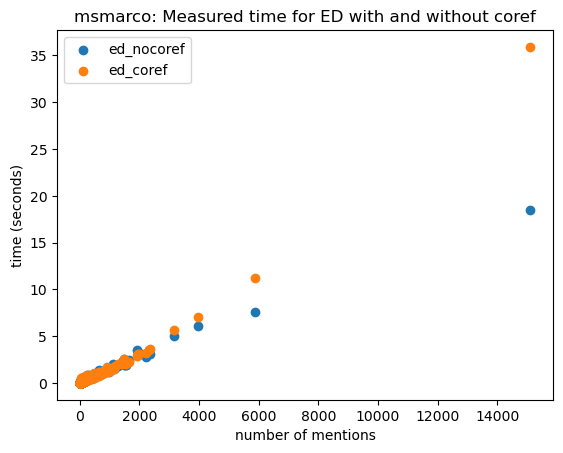

In [22]:
fig, ax = plt.subplots()

for lbl, d in timing_msmarco.items():
    x = d['n_mentions']
    y = d['timing_ed']
    ax.scatter(x=x, y=y, label=lbl)

ax.legend()
ax.set_xlabel("number of mentions")
ax.set_ylabel("time (seconds)")
ax.set_title("msmarco: Measured time for ED with and without coref")

Help on function quantile in module pandas.core.frame:

quantile(self, q: 'float | AnyArrayLike | Sequence[float]' = 0.5, axis: 'Axis' = 0, numeric_only: 'bool | lib.NoDefault' = <no_default>, interpolation: 'QuantileInterpolation' = 'linear', method: "Literal['single', 'table']" = 'single') -> 'Series | DataFrame'
    Return values at the given quantile over requested axis.
    
    Parameters
    ----------
    q : float or array-like, default 0.5 (50% quantile)
        Value between 0 <= q <= 1, the quantile(s) to compute.
    axis : {0 or 'index', 1 or 'columns'}, default 0
        Equals 0 or 'index' for row-wise, 1 or 'columns' for column-wise.
    numeric_only : bool, default True
        If False, the quantile of datetime and timedelta data will be
        computed as well.
    
        .. deprecated:: 1.5.0
            The default value of ``numeric_only`` will be ``False`` in a future
            version of pandas.
    
    interpolation : {'linear', 'lower', 'higher', 'midpo